# Fine-tuning Embeddings for RAG on Specific Data

As we start our "fine-tuning" week, we'll start with the lowest hanging improvement one can do for RAG - which is:

Fine-tuning embeddings!

- 🤝 Breakout Room #1:
  - Task 1: Dependencies and Boilerplate
  - Task 2: Loading Data
  - Task 3: Constructing a Fine-tuning Dataset
  - Task 4: Fine-tuning `snowflake-arctic-embed-l`
  - Task 5: Evaluating our Retriever



#### Basic Overview of Fine-tuning Embeddings

In essence, what we want to do when we fine-tune our embedding models is very simple:

```
Move the embeddings for questions relating to a document
closer together with that document
```

We can think of fine-tuning our embedding models as follows:

1) We have some pair of text items that *should* be closer together
  - `Question`, `Document` pairs
  - EX: `Who drives the bus?`, `The bus was driven by Kyle, the Bus Driver`.

2) We use these pairs as labeled data to fine-tune our embedding model.

The process of training helps the model more accurately associate our questions with the correct documents.

##### ❓ Question #1:

Describe the nuance between using Q&D pairs to train the embedding model vs. inter-document pairs/related sentences.

What caveats does this approach have? Are there any special considerations for what kind of Q's we should use?

##### 😎 ANSWER :
The Q&D approach is explicitly query-oriented and optimizes the question -> document asymmetry.
The inter-document approach is content-oriented and treats texts more symmetrically.


This Q&D approach risks overfitting to specific question formulations and may encounter difficulties with various query styles.
The generated questions may not reflect actual user queries, creating distribution gaps. 

For optimal results, the generated questions should: 
- have varying syntactic structures and levels of complexity
- balance factual, explanatory, and interpretive query types
- include questions requiring nuanced understanding
- be sufficiently specific to the target document rather than generically applicable to multiple documents

## Task 1: Dependencies and Boilerplate

We'll set up our `nest_asyncio` so we can leverage async loops in our Notebook.

We'll also install the required libraries we'll be using today, and set up our OpenAI API key!

### Nest Asyncio

In [1]:
import nest_asyncio

nest_asyncio.apply()

### Install Dependencies

>> NOTE: You do not need to do these steps if you are running this notebook locally with `uv`.

In [2]:
#!pip install -qU langchain_openai langchain_huggingface langchain_core langchain langchain_community langchain-text-splitters

In [3]:
#!pip install -qU faiss-cpu python-pptx==1.0.2 nltk==3.9.1 pymupdf beautifulsoup4 lxml 

### Provide OpenAI API Key

In [4]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter Your OpenAI API Key: ")

## Task 2: Loading Data

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [5]:
!mkdir data

mkdir: data: File exists


In [6]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31536    0 31536    0     0   430k      0 --:--:-- --:--:-- --:--:--  427k


In [7]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70703    0 70703    0     0   691k      0 --:--:-- --:--:-- --:--:--     0--:--:-- --:--:-- --:--:--  697k


In [8]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import BSHTMLLoader

path = "data/"
text_loader = DirectoryLoader(path, glob="*.html", loader_cls=BSHTMLLoader)

Next, we'll set up a classic naive chunking strategy as we only care that the documents get parsed into chunks that we can generate synthetic questions about.

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap  = 20,
    length_function = len
)

Next we can load/split these documents as follows.

> NOTE: You may need to run this cell twice to get it to work.

In [10]:
training_documents = text_splitter.split_documents(text_loader.load())

In [11]:
len(training_documents)

102

Next, we're going to associate each of our chunks with a unique identifier.

In [12]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

Next, we'll simply use naive Python slicing to create a training, test, and validation set to prepare our data for the next step.

In [13]:
training_split_documents = training_documents[:len(training_documents) - 24]
val_split_documents = training_documents[len(training_documents) - 24:102-12]
test_split_documents = training_documents[102-12:]

## Task 3: Constructing a Fine-tuning Dataset

Using the nodes we created above, we can finally start constructing a fine-tuning dataset utilizing OpenAI's `gpt-4.1-mini` 

The basic idea here is straightforward enough:

1. We look at a document
2. We generate questions that could be answered by that node

This gives us a number of question/context pairs that we can use to fine-tune our Embeddings model.

In [14]:
from langchain_openai import ChatOpenAI

qa_chat_model = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0
)

We'll create a simple Question Generation prompt to query `gpt-4o-mini` to generate Questions for each retrieved context.

In [15]:
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be provided in the following format:

1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

We'll create a simple chain to query the LLM!

In [16]:
question_generation_chain = qa_prompt_template | qa_chat_model

There's a lot going on in this function - let's take a deeper look:

1. First, we provide a list of documents and a number of questions
2. We, for each document in our list, generate `n_questions` of questions.
3. We then associate those questions and contexts via a `UUID`.

> NOTE: The reason we're doing this `UUID` association is for ease of use later in the notebook.

##### 🏗️ Activity #1:

We have:

- Lists of `Documents` with the `metadata` field `id`.

We need:

- An object with key `id`, which have values `str` questions.
- An object with key `question_id`, which have values `List(str)` which will be a list of associated `context_id`.

An Example:

question_object:
```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': 'What types of accessible formats are available for persons with disabilities?',
'df58ee4f-714c-419e-8324-94e5870574e2': 'How do accessible formats benefit persons with disabilities?',
'505fce8b-0e56-48de-a251-61027e396918': 'What are some of the risks associated with the increasing capabilities of AI systems that generate synthetic content?',
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': 'Why is it important for providers of AI systems to embed technical solutions for marking and detecting synthetic content?'
}
 ```

 context_object:
 ```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'df58ee4f-714c-419e-8324-94e5870574e2': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'505fce8b-0e56-48de-a251-61027e396918': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
}
 ```

 As you can see, a piece of context can be associated with more than 1 question.

 The task is to write the Python function(s) to accomplish this task.

 Your function signature is provided below, along with the desired return values.

 > NOTE: You can make any modifications that you desire - assuming that you have the correct input and outputs.

In [17]:
import tqdm
import asyncio
import re


async def create_questions(documents, n_questions):

    questions = {}
    relevant_docs = {}

    progress_bar = tqdm.tqdm(total=len(documents), desc="Processing documents")
    
    for document in documents:
        context = document.page_content
        doc_id = document.metadata["id"]
        
        chain_output = await question_generation_chain.ainvoke({
            "context": context,
            "n_questions": n_questions
        })
        

        generated_questions = chain_output.content
        
        question_lines = generated_questions.strip().split("\n")
        
        for q_line in question_lines:
            if not q_line.strip():
                continue
                
            q_text = re.sub(r'^\d+\.\s+', '', q_line.strip())
                
            # Générer un ID unique pour chaque question
            q_id = str(uuid.uuid4())
            
            # Stocker la question et sa relation avec le document
            questions[q_id] = q_text
            relevant_docs[q_id] = [doc_id]
             # Mettre à jour la barre de progression
        progress_bar.update(1)
    
    progress_bar.close()
    
    return questions, relevant_docs

### REMOVE `await` IF NOT USING ASYNC (HINT: Use `async`)

In [18]:
training_questions, training_relevant_contexts = await create_questions(training_split_documents, 2)

Processing documents: 100%|██████████| 78/78 [01:36<00:00,  1.24s/it]


We'll use the function to generate training, validation, and test data.

In [19]:
val_questions, val_relevant_contexts = await create_questions(val_split_documents, 2)

Processing documents: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it]


In [20]:
test_questions, test_relevant_contexts = await create_questions(test_split_documents, 2)

Processing documents: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


### Reformating and Saving Datasets

Now, we can save our datasets for later use!

In [23]:
import json

training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

train_dataset = {
    "questions" : training_questions,
    "relevant_contexts" : training_relevant_contexts,
    "corpus" : training_corpus
}

with open("training_dataset.jsonl", "w") as f:
  json.dump(train_dataset, f)

In [24]:
val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset.jsonl", "w") as f:
  json.dump(val_dataset, f)

In [25]:
train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : train_corpus
}

with open("test_dataset.jsonl", "w") as f:
  json.dump(test_dataset, f)

## Task 4: Fine-tuning `snowflake-arctic-embed-l`

Now that we have a dataset, let's grab a `sentence-transformers` Embeddings model!

We'll be using Snowflake's [`snowflake-arctic-embed-l`](https://huggingface.co/Snowflake/snowflake-arctic-embed-l) as a base embeddings model.

It is a well performing embeddings model by itself, but there's a lot of very specific domain terms and vocabulary in our courpus - so lets fine-tune it and see what that can do for us!

>> NOTE: Skip installing dependencies if you are running this notebook locally.

In [ ]:
#!pip install -qU sentence_transformers datasets pyarrow

In [26]:
from sentence_transformers import SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-l"
model = SentenceTransformer(model_id)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/85.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

We'll grab some necessary imports from `sentence_transformers` and `torch`.

> NOTE: PyTorch (`torch`) is a popular machine learning library - while we don't go very deep into PyTorch it's an incredibly powerful and interesting library! Please read more about it [here](https://pytorch.org/tutorials/beginner/basics/intro.html)!

In [28]:
import torch

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: mps


In [29]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

We're using a toy batch size here to reflect the limited number of examples we have.

> NOTE: It is typical to use a much larger batch size (~64+), hardware permitting.

In [46]:
BATCH_SIZE = 2

model = model.to(device)
print(f"Model moved to {device}")

Model moved to mps


Let's move our dataset into the expected format for training.

In [47]:
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

Now we can create a `torch` `DataLoader`!

In [48]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

Next up, we'll prepare our loss function!

Loss is an important part of training, fine-tuning, and more. If you want a deep dive on loss - you can check out our [event on loss!](https://www.youtube.com/watch?v=iB8FWR9aD5Q&t=8s).

The core loss we're using today is called `MultipleNegativesRankingLoss` - you can find more information [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MultipleNegativesRankingLoss.py).

This is "wrapped" in `MatryoshkaLoss`, which you can read the implementation of [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MatryoshkaLoss.py).

In [49]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

##### 🏗️ Activity #2:

Both of these losses sound "cool", but what are they - exactly - under the hood?

Why are these losses specifically doing? Please write a short summary of each loss.

> NOTE: This is a course focused on AI Engineering and the application of AI - looking for a hint? Try pasting the code (linked above) into ChatGPT/Claude to write the summary!

#### 😎 ANSWER :

**MultipleNegativesRankingLoss (under the hood)**
It is a contrastive loss function that operates on pairs of examples (anchor, positive) while using all other examples in the batch as negatives. 
For each question (anchor), it:
1. Takes a positive document (the one that answers the question)
2. Treats all other documents in the batch as negatives
3. Computes the cosine similarity between the question and all documents
4. Applies softmax to convert these similarities into probabilities
5. Maximizes the probability of the positive document by minimizing the negative log-likelihood

This approach is efficient because it uses the entire batch as a source of negative examples, thus avoiding the need for manual negative sampling.

**MatryoshkaLoss (under the hood)**
Il is a meta-loss function that creates multi-dimensional nested embeddings, it:

1. wraps the MultipleNegativesRankingLoss loss function
2. generates the full embedding at the maximum dimension (768)
3. takes subsections of this embedding to create smaller versions (512, 256, 128, 64)
4. applies the internal loss function to each dimension
5. calculates the final loss as a weighted sum of the losses at each dimension

This approach allows for a flexible embedding model that can produce representations of different sizes without requiring separate models, balancing accuracy (higher dimensions) and efficiency (smaller dimensions) as needed.

Now we can set-up our evaluator.

> NOTE: Due to the formatting of our dataset - this is all we have to do!

In [50]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

We'll train this model for 5 epochs, though you could increase this number if we had a significant amount more data.

In [51]:
EPOCHS = 5

It's training time!

> NOTE: We're manually defining a warm-up period here - this is just to provide a smooth ramp into our training!

In [52]:
import wandb
wandb.init(mode="disabled")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


> NOTE: You may not see direct improvement during the training cycles - this is absolutely expected. We will verify performance later in the notebook. 

In [53]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic_ft',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50
)

/Users/jthomazo/Archives/01_Projets/02_AIM/AIE6/09_Finetuning_Embeddings/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
50,No log,No log,0.875000,0.958333,1.000000,1.000000,0.875000,0.319444,0.200000,0.100000,0.875000,0.958333,1.000000,1.000000,0.940067,0.920139,0.920139
78,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.948411,0.930556,0.930556
100,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.948411,0.930556,0.930556
150,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
156,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
200,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
234,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
250,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
300,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
312,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333


In [ ]:
from huggingface_hub import login

hf_token = getpass.getpass("Enter your Hugging Face token: ")
login(token=hf_token)

In [67]:
hf_username = "JTh34"

In [68]:
import uuid

model.push_to_hub(f"{hf_username}/legal-ft-{uuid.uuid4()}")

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

'https://huggingface.co/JTh34/legal-ft-d96db3a6-7757-4595-b021-1e01c6b3a769/commit/34306ad041e5f1693dc4cf4de754adf82caa8c8e'

## Task 5: Evaluating our Retriever

Now that we have fine-tuned our retriever - let's see if it's worthwhile!

We'll start with some basic imports.

In [69]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

Now we'll define a function that will help us evaluate our retrieval process.

> NOTE: We're assuming 1 correct document in a "hit".

In [70]:
def evaluate_openai(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  eval_results = []
  for id, question in tqdm.tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

All that's left to do is evaluate, we'll evaluate our model against:

1. OpenAI's closed source `text-embedding-3-small`
2. The base non-fine-tuned version of `Snowflake/snowflake-arctic-embed-l`.

Let's see how it stacks up!

### `text-embedding-3-small`

In [71]:
te3_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te3_results = evaluate_openai(test_dataset, te3_openai)

100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


In [72]:
te3_results_df = pd.DataFrame(te3_results)

In [73]:
te3_hit_rate = te3_results_df["is_hit"].mean()
te3_hit_rate

np.float64(0.9583333333333334)

### `Snowflake/snowflake-arctic-embed-l` (base)

In [74]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-l")
arctic_embed_m_results = evaluate_openai(test_dataset, huggingface_embeddings)

100%|██████████| 24/24 [00:02<00:00, 11.61it/s]


In [75]:
arctic_embed_m_results_df = pd.DataFrame(arctic_embed_m_results)

In [76]:
arctic_embed_m_hit_rate = arctic_embed_m_results_df["is_hit"].mean()
arctic_embed_m_hit_rate

np.float64(0.7916666666666666)

### `Snowflake/snowflake-arctic-embed-l` (fine-tuned)

In [78]:
finetune_embeddings = HuggingFaceEmbeddings(model_name="finetuned_arctic_ft")
finetune_results = evaluate_openai(test_dataset, finetune_embeddings)

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic_ft and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 24/24 [00:00<00:00, 38.69it/s]


In [79]:
finetune_results_df = pd.DataFrame(finetune_results)

In [80]:
finetune_hit_rate = finetune_results_df["is_hit"].mean()
finetune_hit_rate

np.float64(1.0)

## Task 1: Vibe Checking the RAG Pipeline

We're going to use our RAG pipeline to vibe check on some common phrases now that we've modified it!

### Creating New Chunks

In order to try and evaluate our system more fairly, let's create new chunks that we will use to create our Vector Store.

In [81]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap  = 50,
    length_function = len
)

training_documents = text_splitter.split_documents(text_loader.load())

### Base Chain

We'll start by constructing our base chain, which will use the untrained retrieval model.

#### R - Retrieval

In [82]:
from langchain_community.vectorstores import FAISS

base_vectorstore = FAISS.from_documents(training_documents, huggingface_embeddings)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})

#### A - Augmented

In [83]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and a question, you must answer the question. If you do not know the answer, you must state that you do not know.

Context:
{context}

Question:
{question}

Answer:
"""

rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)

#### G - Generation

In [84]:
rag_llm =  ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0
)

#### RAG - LCEL RAG Pipeline

In [85]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [86]:
base_rag_chain.invoke({"question" : "What is an agent?"})["response"]

'Based on the provided context, an "agent" in the context of AI refers to systems that can act on your behalf, such as travel agents or digital assistants. However, the term is highly vague and lacks a clear, universally accepted definition. Different people interpret "agents" differently—some see them as AI systems that perform tasks independently, while others think of them as tools that access and use various resources or tools to solve problems. The discussions also highlight that true autonomous agents are still "coming soon" and that current implementations often face challenges like gullibility and the inability to distinguish truth from fiction.'

In [87]:
base_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'Organizations that have produced better-than-GPT-3 class models include Anthropic, Mistral, Google, Meta, EleutherAI, Stability AI, TII in Abu Dhabi (Falcon), Microsoft Research, xAI, Replit, Baidu, and others.'

In [91]:
base_rag_chain.invoke({"question" : "What is the laziest time of the year for AI?"})["response"]

'The provided context does not specify a particular time of year that is considered the "laziest" for AI.'

In [92]:
base_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'The provided context does not specify the name Simon or detail the largest model he has run on his phone.'

### Fine-tuned Embedding Model

Now let's rebuild our RAG chain with the Fine-tuned model - the only component we need to change is our `FAISS` vectorstore!

In [93]:
finetune_vectorstore = FAISS.from_documents(training_documents, finetune_embeddings)
finetune_retriever = finetune_vectorstore.as_retriever(search_kwargs={"k": 6})

In [94]:
finetune_rag_chain = (
    {"context": itemgetter("question") | finetune_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [95]:
finetune_rag_chain.invoke({"question" : "What is an Agent?"})["response"]

'Based on the provided context, an "agent" is a term that is used in various ways but lacks a clear, universally accepted definition. Some people think of agents as systems that act on your behalf, similar to a travel agent, while others consider them as LLMs that have access to tools and can operate in loops to solve problems. However, the term remains vague and often causes frustration because it doesn\'t specify what exactly is meant. Overall, an agent can be thought of as an AI system designed to perform tasks or make decisions, but the specific meaning varies depending on the context and the speaker.'

In [96]:
finetune_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'The provided context does not specify which organizations have produced models better than GPT-3. It mentions that in 2024, many models now surpass GPT-4, but there is no direct information about models that have surpassed GPT-3 specifically.'

In [97]:
finetune_rag_chain.invoke({"question" : "What is the laziest time of the year for AI?"})["response"]

'The provided context suggests that AI models, such as ChatGPT, may become less useful or "lazy" during certain times, specifically around the holidays. One excerpt mentions that ChatGPT might get lazy in December because its hidden system prompt includes the current date, and the training data shows that people tend to provide less useful answers leading up to the holidays. Therefore, the laziest time of the year for AI appears to be December.'

In [98]:
finetune_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'The largest model that Simon has run on his phone is Mistral 7B.'

#### ❓Question #2:

Which LCEL RAG Chain do you think answered the questions better, and why?

#### 😎 ANSWER:
The fine-tuned RAG chain seems to have performed better overall for these domain-specific questions.

According to me, the reasons are :

1. **A better context specificity**: The fine-tuned model retrieved more relevant context for domain-specific queries. 

2. **An improved matching of terminology**: The fine-tuning process helped align the embedding space between the specialized AI terminology in the questions and the corresponding passages in the documents.

3. **A deeper conceptual understanding**: The response of the fine-tuned embedding about "agents" showed more nuance about the ambiguity of the term, suggesting it retrieved a more comprehensive selection of relevant passages.

## Task 2: RAGAS Evaluation

It's great to have some idea of how our system is doing based on vibe-checks, but let's use RAGAS to provide more insight info. on how things are improving!

> NOTE: Please recreate *exactly* the RAGAS process we used to evaluate RAG, baselining with the default retriever, and then comparing the new retriever. The includes the Synthetic Data Generation steps.

In [100]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas.testset import TestsetGenerator
from ragas import EvaluationDataset
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

# Generate SDG
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
testset_dataset = generator.generate_with_langchain_docs(training_documents, testset_size=10)

testset_df = testset_dataset.to_pandas()
print(testset_df)

Applying SummaryExtractor:   0%|          | 0/83 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/128 [00:00<?, ?it/s]

Node 918ded31-f04b-4f6a-acaa-66bd556444ed does not have a summary. Skipping filtering.
Node 6d478aab-21d7-41c2-bd7e-3f402124b9b8 does not have a summary. Skipping filtering.
Node a8212946-89db-4c62-914e-95b085472ea4 does not have a summary. Skipping filtering.
Node 65e4662f-6a2a-41c5-af87-f7e031c29bad does not have a summary. Skipping filtering.
Node e88b96d7-ff52-4747-9933-7134ac10b661 does not have a summary. Skipping filtering.
Node cbcea7fa-55de-46a3-b8bc-a651fad135a6 does not have a summary. Skipping filtering.
Node 3ba4ce44-d2f6-49b0-800c-29d0227b19f7 does not have a summary. Skipping filtering.
Node 86edbd62-e002-450c-bc61-886a48b1e39b does not have a summary. Skipping filtering.
Node 56113fc2-abab-49b8-b977-9035684ff9e2 does not have a summary. Skipping filtering.
Node 2273f27f-b9d7-4040-b3d3-e6082bacbc9b does not have a summary. Skipping filtering.
Node bcc2ec41-48d5-431f-b6f0-75185e5fdd75 does not have a summary. Skipping filtering.
Node 33dba174-4bc2-4f38-a7b9-4c25b6412df1 d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/339 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

                                           user_input  \
0   who is simon willison and what he say about ai...   
1                             how LLMs easy to build?   
2   What capabilities do Large Language Models hav...   
3   How come big language models is easy to build ...   
4   why Apple MLX library is good but we still no ...   
5   how GPT-4 advancements and bing chat manipulat...   
6   How does the problem of LLM hallucination rela...   
7   How do large language models and AI agents rel...   
8   Considering the advancements in AI model capab...   
9   Hw did Microsoft Research and Microsoft contri...   
10  How does the cost efficiency of GPT-4o mini co...   
11  how deepseek v3 use reasoning data from deepse...   

                                   reference_contexts  \
0   [Stuff we figured out about AI in 2023\n\n\n\n...   
1   [Large Language Models\nThey’re actually quite...   
2   [Here’s the sequel to this post: Things we lea...   
3   [They’re actually quite ea

In [103]:
# Base retriever
for test_row in testset_dataset:
    response = base_rag_chain.invoke({"question": test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"]
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

# Convert to EvaluationDataset for RAGAS
from ragas import EvaluationDataset
base_evaluation_dataset = EvaluationDataset.from_pandas(testset_dataset.to_pandas())

# Fine-tuned retriever
# Créer un nouveau jeu de données à partir du même DataFrame
finetuned_testset_df = testset_dataset.to_pandas()
# Utiliser directement le même dataset mais avec des réponses différentes
# TestsetGenerator n'a pas de méthode from_pandas, nous utilisons donc une approche différente
finetuned_testset_dataset = testset_dataset

for test_row in finetuned_testset_dataset:
    response = finetune_rag_chain.invoke({"question": test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"]
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

# Convert to EvaluationDataset for RAGAS
finetuned_evaluation_dataset = EvaluationDataset.from_pandas(finetuned_testset_dataset.to_pandas())

# Evaluator LLM 
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))


custom_run_config = RunConfig(
    timeout=600,
    max_workers=2  
)

In [104]:
# Evaluate the base retriever
base_result = evaluate(
    dataset=base_evaluation_dataset,
    metrics=[
        LLMContextRecall(), 
        Faithfulness(), 
        FactualCorrectness(), 
        ResponseRelevancy(), 
        ContextEntityRecall(), 
        NoiseSensitivity()
    ],
    llm=evaluator_llm,
    run_config=custom_run_config
)
print("Base retriever results:")
print(base_result)

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Base retriever results:
{'context_recall': 0.5000, 'faithfulness': 0.8076, 'factual_correctness(mode=f1)': 0.3992, 'answer_relevancy': 0.5428, 'context_entity_recall': 0.4176, 'noise_sensitivity(mode=relevant)': 0.0625}


In [105]:
finetuned_result = evaluate(
    dataset=finetuned_evaluation_dataset,
    metrics=[
        LLMContextRecall(), 
        Faithfulness(), 
        FactualCorrectness(), 
        ResponseRelevancy(), 
        ContextEntityRecall(), 
        NoiseSensitivity()
    ],
    llm=evaluator_llm,
    run_config=custom_run_config
)
print("Fine-tuned retriever results:")
print(finetuned_result)

Evaluating fine-tuned retriever...


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Fine-tuned retriever results:
{'context_recall': 0.7083, 'faithfulness': 0.8711, 'factual_correctness(mode=f1)': 0.4525, 'answer_relevancy': 0.6958, 'context_entity_recall': 0.6237, 'noise_sensitivity(mode=relevant)': 0.3344}



Metrics Comparison:
context_recall:
  Base: 0.5000
  Fine-tuned: 0.7083
  Absolute difference: 0.2083
  Relative improvement: 41.67%

faithfulness:
  Base: 0.8076
  Fine-tuned: 0.8711
  Absolute difference: 0.0634
  Relative improvement: 7.85%

factual_correctness:
  Base: 0.3992
  Fine-tuned: 0.4525
  Absolute difference: 0.0533
  Relative improvement: 13.36%

answer_relevancy:
  Base: 0.5428
  Fine-tuned: 0.6958
  Absolute difference: 0.1530
  Relative improvement: 28.19%

context_entity_recall:
  Base: 0.4176
  Fine-tuned: 0.6237
  Absolute difference: 0.2061
  Relative improvement: 49.34%

noise_sensitivity:
  Base: 0.0625
  Fine-tuned: 0.3344
  Absolute difference: 0.2719
  Relative improvement: 435.02%



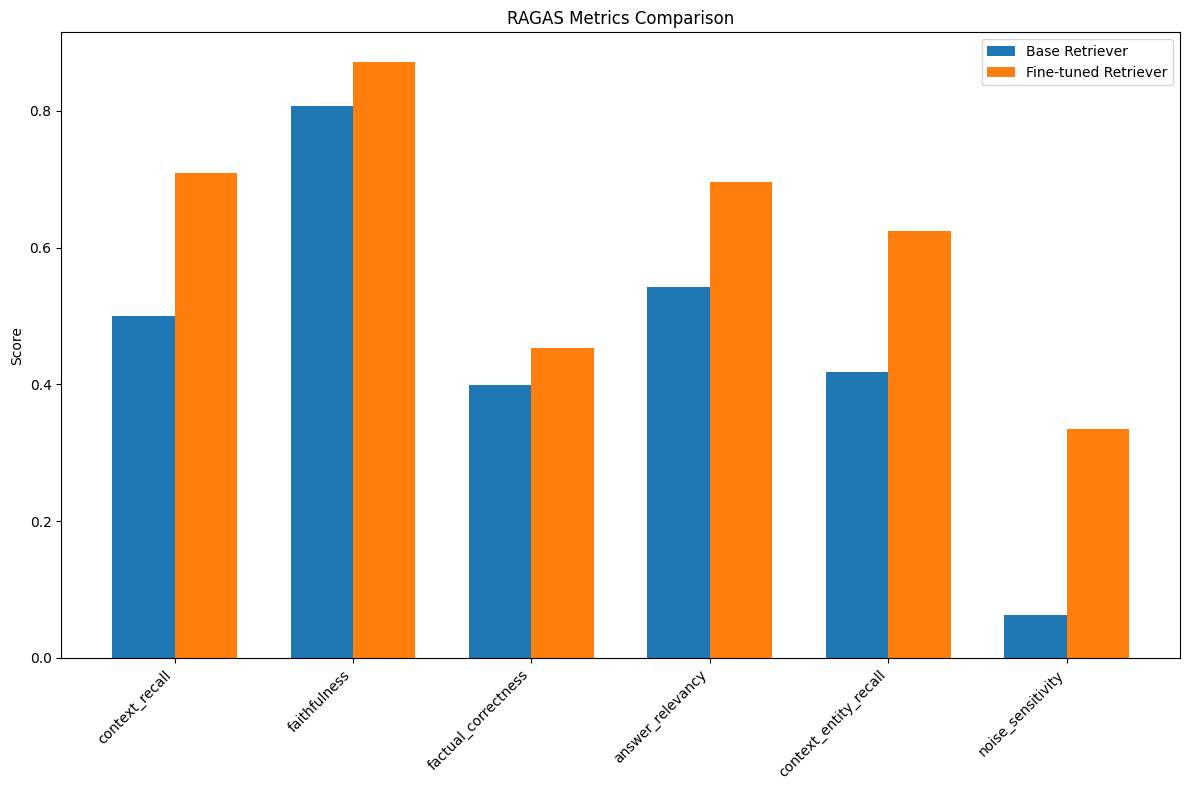

In [112]:
# Visualize the comparison
import matplotlib.pyplot as plt
import numpy as np

# Compare the results
print("\nMetrics Comparison:")
# Access metrics through the EvaluationResult object dictionary
metrics = {
    "context_recall": "context_recall",
    "faithfulness": "faithfulness",
    "factual_correctness": "factual_correctness(mode=f1)",
    "answer_relevancy": "answer_relevancy",
    "context_entity_recall": "context_entity_recall",
    "noise_sensitivity": "noise_sensitivity(mode=relevant)"
}

# List to store valid metric names
valid_metrics = []
base_values = []
finetuned_values = []

for display_name, metric_key in metrics.items():
    try:
        # Try to access metrics through the results dictionary
        base_value = base_result[metric_key]
        finetuned_value = finetuned_result[metric_key]
        
        # Check if values are lists and extract the average if so
        if isinstance(base_value, list):
            base_value = np.mean(base_value)
        if isinstance(finetuned_value, list):
            finetuned_value = np.mean(finetuned_value)
        
        difference = finetuned_value - base_value
        improvement = difference / base_value * 100 if base_value != 0 else float('inf')
        
        print(f"{display_name}:")
        print(f"  Base: {base_value:.4f}")
        print(f"  Fine-tuned: {finetuned_value:.4f}")
        print(f"  Absolute difference: {difference:.4f}")
        print(f"  Relative improvement: {improvement:.2f}%")
        print()
        
        # Store values for the chart
        valid_metrics.append(display_name)
        base_values.append(base_value)
        finetuned_values.append(finetuned_value)
    except (KeyError, AttributeError, TypeError) as e:
        print(f"Metric '{display_name}' not available or error: {str(e)}")

# Create the chart only with valid metrics
if valid_metrics:
    x = np.arange(len(valid_metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width/2, base_values, width, label='Base Retriever')
    rects2 = ax.bar(x + width/2, finetuned_values, width, label='Fine-tuned Retriever')

    ax.set_ylabel('Score')
    ax.set_title('RAGAS Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_metrics, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No valid metrics found to create the chart.")
